# Selective Inference via outcome Randomisation and Mirror Statistics

In [1]:
using Pkg
Pkg.status()

using GLM
using GLMNet
using Distributions
using Random
using StatsPlots
using Plots
using DataFrames

Project selective_inference_project v0.1.0
Status `~/Documents/UiO_Postdoc/Code/git_repositories/SelectiveInference/Project.toml`
⌃ [31c24e10] Distributions v0.25.100
⌃ [38e38edf] GLM v1.8.3
  [8d5ece8b] GLMNet v0.7.2
⌃ [6f49c342] RCall v0.13.17
  [f3b207a7] StatsPlots v0.15.6
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [33]:
include("./utilities/data_generation.jl")
include("./utilities/randomisation_ds.jl")
include("./utilities/mirror_statistic.jl")
include("./utilities/classification_metrics.jl");

Main.classification_metrics

In [2]:
include("./wrapper_pipeline_inference.jl")

Main.wrapper_pipeline_inference

In [3]:
function print_metrics(;scenario, results)
    println("-------------------- $scenario --------------------")

    fdr_mirror_statistic = round(results.fdr_mirror_statistic, digits=3)
    println("FDR using Mirror Statistic: $fdr_mirror_statistic")

    fdr_randomisation_raw = round(results.fdr_randomisation_raw, digits=3)
    println("FDR using Randomisation Raw: $fdr_randomisation_raw")

    fdr_randomisation_bh = round(results.fdr_randomisation_bh, digits=3)
    println("FDR using Randomisation with BH: $fdr_randomisation_bh")

    tpr_mirror_statistic = round(results.tpr_mirror_statistic, digits=3)
    println("TPR using Mirror Statistic: $tpr_mirror_statistic")

    tpr_randomisation_raw = round(results.tpr_randomisation_raw, digits=3)
    println("TPR using Randomisation: $tpr_randomisation_raw")
end

print_metrics (generic function with 1 method)

## Simulation on uncorrelated covariates

### Low-dimensional case
30% of coefficients are 0

In [12]:
n = 100
p = 20
prop_zero_coef = 0.3
beta_intercept = 1.
sigma2 = 1.
correlation_coefficients = []
scenario = "Low-Dimensional, No Correlation"

"Low-Dimensional, No Correlation"

In [13]:
Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [14]:
print_metrics(scenario=scenario, results=results)

-------------------- Low-Dimensional, No Correlation --------------------
FDR using Mirror Statistic: 0.125
FDR using Randomisation Raw: 0.0
FDR using Randomisation with BH: 0.0
TPR using Mirror Statistic: 1.0
TPR using Randomisation: 1.0


### High-dimensional case
70% of coefficients are 0

In [15]:
n = 100
p = 200
prop_zero_coef=0.7
beta_intercept=1.
sigma2=1.
correlation_coefficients=[]
scenario = "High-Dimensional, No Correlation"

Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [16]:
print_metrics(scenario=scenario, results=results)

-------------------- High-Dimensional, No Correlation --------------------
FDR using Mirror Statistic: 0.382
FDR using Randomisation Raw: 0.312
FDR using Randomisation with BH: 0.0
TPR using Mirror Statistic: 0.567
TPR using Randomisation: 0.183


## Correlated covariates

### Low-dimensional case
30% of coefficients are 0

In [17]:
n = 100
p = 20
prop_zero_coef=0.3
beta_intercept=1.
sigma2=1.
correlation_coefficients=[0.5, 0.3]
scenario = "Low-Dimensional, With Correlation"

Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [18]:
print_metrics(scenario=scenario, results=results)

-------------------- Low-Dimensional, With Correlation --------------------
FDR using Mirror Statistic: 0.176
FDR using Randomisation Raw: 0.0
FDR using Randomisation with BH: 0.0
TPR using Mirror Statistic: 1.0
TPR using Randomisation: 0.929


### High-dimensional case
70% of coefficients are 0

In [19]:
n = 100
p = 200
prop_zero_coef=0.7
beta_intercept=1.
sigma2=1.
correlation_coefficients=[0.5, 0.3]
scenario = "High-Dimensional, With Correlation"

Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [20]:
print_metrics(scenario=scenario, results=results)

-------------------- High-Dimensional, With Correlation --------------------
FDR using Mirror Statistic: 0.333
FDR using Randomisation Raw: 0.0
FDR using Randomisation with BH: 0.0
TPR using Mirror Statistic: 0.1
TPR using Randomisation: 0.0


### High-dimensional case, but less correlated covariates

In [23]:
n = 100
p = 200
prop_zero_coef=0.7
beta_intercept=1.
sigma2=1.
correlation_coefficients=[0.5]
scenario = "High-Dimensional, With less Correlation"

Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [24]:
print_metrics(scenario=scenario, results=results)

-------------------- High-Dimensional, With less Correlation --------------------
FDR using Mirror Statistic: 0.453
FDR using Randomisation Raw: 0.48
FDR using Randomisation with BH: 0.5
TPR using Mirror Statistic: 0.483
TPR using Randomisation: 0.217


### High-dimensional case, lower proportion on non-zero coefficients

In [28]:
n = 100
p = 200
prop_zero_coef=0.9
beta_intercept=1.
sigma2=1.
correlation_coefficients=[0.5]
scenario = "High-Dimensional, With less Correlation and 90% of zero coefficients"

Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [29]:
print_metrics(scenario=scenario, results=results)

-------------------- High-Dimensional, With less Correlation and 90% of zero coefficients --------------------
FDR using Mirror Statistic: 0.053
FDR using Randomisation Raw: 0.125
FDR using Randomisation with BH: 0.0
TPR using Mirror Statistic: 0.9
TPR using Randomisation: 0.7


### High-dimensional case, lower proportion on non-zero coefficients, higher correlation

In [30]:
n = 100
p = 200
prop_zero_coef=0.9
beta_intercept=1.
sigma2=1.
correlation_coefficients=[0.5, 0.3]
scenario = "High-Dimensional, With higher Correlation and 90% of zero coefficients"

Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [31]:
print_metrics(scenario=scenario, results=results)

-------------------- High-Dimensional, With higher Correlation and 90% of zero coefficients --------------------
FDR using Mirror Statistic: 0.05
FDR using Randomisation Raw: 0.062
FDR using Randomisation with BH: 0.0
TPR using Mirror Statistic: 0.95
TPR using Randomisation: 0.75


### High-dimensional case, 20% on non-zero coefficients, positive and negative correlations

In [49]:
n = 100
p = 200
prop_zero_coef=0.8
beta_intercept=1.
sigma2=1.
correlation_coefficients=[0.3, -0.2]
scenario = "High-Dimensional, With positive and negative Correlations and 80% of zero coefficients"

Random.seed!(1345)
results = wrapper_pipeline_inference.wrapper_randomisation_inference(
    n=n,
    p=p,
    correlation_coefficients=correlation_coefficients,
    prop_zero_coef=prop_zero_coef,
    sigma2=sigma2,
    gamma_randomisation=1.,
    fdr_level=0.1
);

In [50]:
print_metrics(scenario=scenario, results=results)

-------------------- High-Dimensional, With positive and negative Correlations and 80% of zero coefficients --------------------
FDR using Mirror Statistic: 0.308
FDR using Randomisation Raw: 0.364
FDR using Randomisation with BH: 0.0
TPR using Mirror Statistic: 0.45
TPR using Randomisation: 0.35


## Focus on High-Dimensional scenarios
Gradually increase the correlation structure and the proportion of non-zero coefficients

In [21]:
correlations_first_offdiag = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
correlations_second_offdiag = [0., 0.1, 0.2, 0.3, 0.4]
proportions_zero_coef = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7];

In [22]:
tot_simulations = length(correlations_first_offdiag) * length(correlations_second_offdiag) * length(proportions_zero_coef)
colnames = ["corr_first", "corr_second", "prop_non_zero", "FDR_Rand", "FDR_MS", "TPR_Rand", "TPR_MS"];

In [25]:
df_metrics = DataFrames.DataFrame([name => [] for name in colnames]);

In [26]:
n = 100
p = 200
beta_intercept=1.
sigma2=1.
n_replica = 10

for corr_first in correlations_first_offdiag
    println("Executing correlation $corr_first")
    for corr_sec in correlations_second_offdiag
        for prop_zero in proportions_zero_coef

            Random.seed!(1345)
            scenario = "Correlations: $corr_first and $corr_sec. Proportion $prop_zero of zero coefficients"
            correlation_coefficients=[corr_first, corr_sec]
            
            fdr_randomisation_mean = 0.
            fdr_mirror_statistic_mean = 0.
            tpr_randomisation_mean = 0.
            tpr_mirror_statistic_mean = 0.

            # Do an average over 5 replications for each combination
            for replica in range(1, n_replica)
                results = wrapper_pipeline_inference.wrapper_randomisation_inference(
                    n=n,
                    p=p,
                    correlation_coefficients=correlation_coefficients,
                    prop_zero_coef=prop_zero,
                    sigma2=sigma2,
                    gamma_randomisation=1.,
                    fdr_level=0.1
                )
                fdr_randomisation_mean += results.fdr_randomisation_raw
                fdr_mirror_statistic_mean += results.fdr_mirror_statistic
                tpr_randomisation_mean += results.tpr_randomisation_raw
                tpr_mirror_statistic_mean += results.tpr_mirror_statistic
            end

            push!(
                df_metrics,
                [
                    corr_first,
                    corr_sec,
                    1-prop_zero,
                    fdr_randomisation_mean / n_replica,
                    fdr_mirror_statistic_mean / n_replica,
                    tpr_randomisation_mean / n_replica,
                    tpr_mirror_statistic_mean / n_replica
                ]
            )

        end
    end
end
;

Executing correlation 0.0


Executing correlation 0.1


Executing correlation 0.2


Executing correlation 0.3


Executing correlation 0.4


Executing correlation 0.5


In [44]:
df_metrics

Row,corr_first,corr_second,prop_non_zero,FDR_Rand,FDR_MS,TPR_Rand,TPR_MS
,Any,Any,Any,Any,Any,Any,Any
1,0.0,0.0,0.05,0.14596,0.186497,0.9,0.93
2,0.0,0.0,0.1,0.0551774,0.153661,0.665,0.87
3,0.0,0.0,0.15,0.183191,0.283237,0.383333,0.67
4,0.0,0.0,0.2,0.213676,0.322825,0.3875,0.5825
5,0.0,0.0,0.25,0.255766,0.313478,0.262,0.424
6,0.0,0.0,0.3,0.141746,0.379112,0.135,0.411667
7,0.0,0.1,0.05,0.128586,0.15565,0.9,0.94
8,0.0,0.1,0.1,0.0795662,0.128031,0.71,0.885
9,0.0,0.1,0.15,0.239926,0.305414,0.416667,0.676667


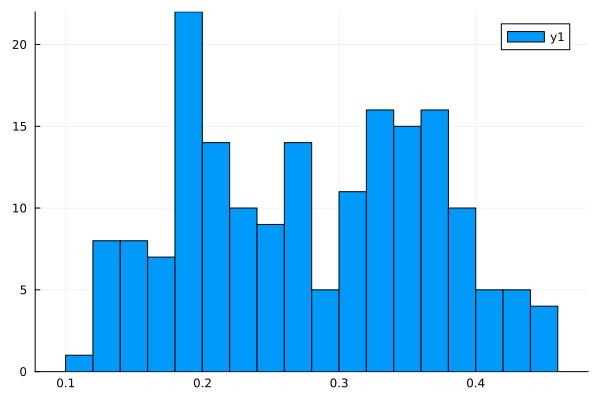

In [47]:
histogram(df_metrics.FDR_MS, bins=20)

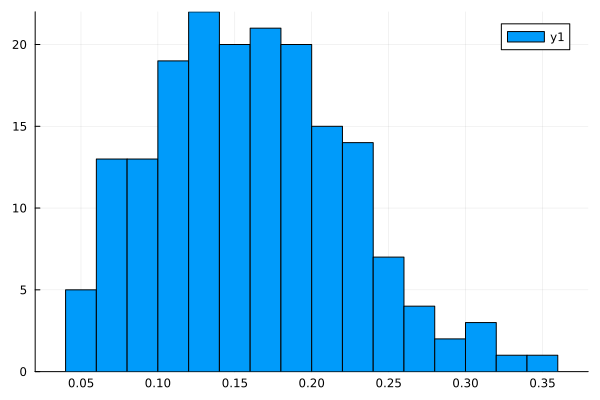

In [48]:
histogram(df_metrics.FDR_Rand, bins=20)

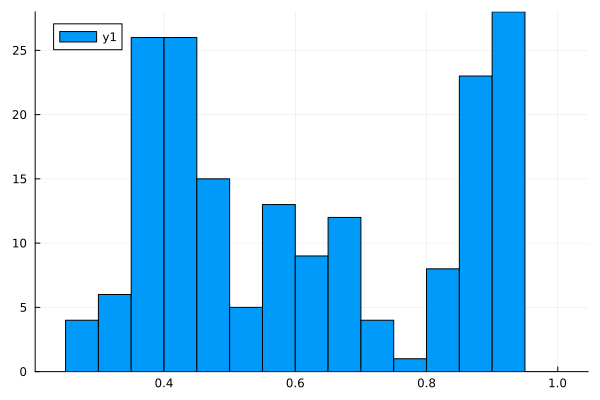

In [49]:
histogram(df_metrics.TPR_MS, bins=20)

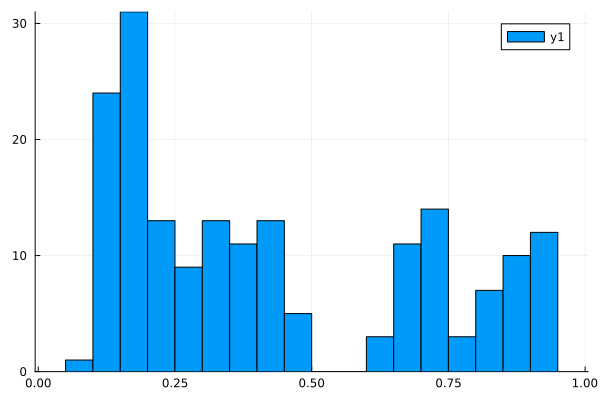

In [50]:
histogram(df_metrics.TPR_Rand, bins=20)